Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.V69UF0_3.2.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.V69UF0_3.2.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.
Epoch 1/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 2222s 10s/step - accuracy: 0.0000e+00 - loss: 0.0865 - val_accuracy: 0.0000e+00 - val_loss: 0.0424
Epoch 2/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 2147s 9s/step - accuracy: 0.0000e+00 - loss: 0.0423 - val_accuracy: 0.0000e+00 - val_loss: 0.0425
Epoch 3/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 2196s 10s/step - accuracy: 0.0000e+00 - loss: 0.0423 - val_accuracy: 0.0000e+00 - val_loss: 0.0425
Epoch 4/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 2196s 10s/step - accuracy: 0.0000e+00 - loss: 0.0423 - val_accuracy: 0.0000e+00 - val_loss: 0.0424
Epoch 5/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 2135s 9s/step - accuracy: 0.0000e+00 - loss: 0.0423 - val_accuracy: 0.0000e+00 - val_loss: 0.0424
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


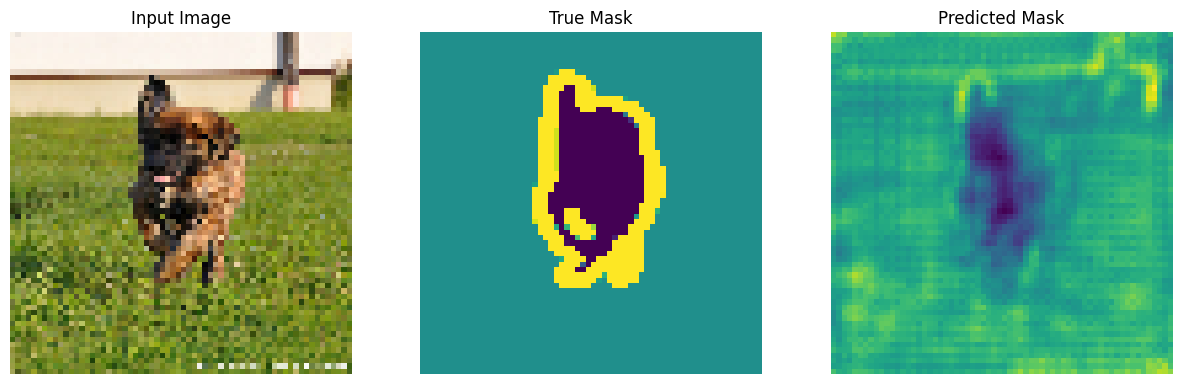

In [1]:
import tensorflow as tf  # Импортируем библиотеку TensorFlow, которая используется для построения и обучения нейронных сетей.
import tensorflow_datasets as tfds  # Импортируем TensorFlow Datasets для удобной загрузки и обработки стандартных датасетов.
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input  # Импортируем необходимые слои для создания модели U-Net.
from tensorflow.keras.models import Model  # Импортируем класс Model для создания модели на основе функционального API Keras.
import matplotlib.pyplot as plt  # Импортируем библиотеку matplotlib для визуализации изображений и результатов работы модели.

# Параметры модели и данных
BATCH_SIZE = 16  # Размер пакета для обучения модели.
IMG_SIZE = 64  # Размер изображений, к которому они будут приведены (128x128).
AUTOTUNE = tf.data.experimental.AUTOTUNE  # Оптимизация загрузки данных путем автоматического определения количества потоков.

# Функция для нормализации изображений и масок
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0  # Преобразуем изображение в формат с плавающей точкой и нормализуем его значения в диапазон [0, 1].
    input_mask = tf.cast(input_mask, tf.float32) / 255.0  # Преобразуем маску в формат с плавающей точкой и нормализуем ее значения в диапазон [0, 1].
    return input_image, input_mask  # Возвращаем нормализованные изображение и маску.

# Функция для загрузки и предобработки изображения и маски
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))  # Изменяем размер изображения до 128x128 пикселей.
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))  # Изменяем размер маски до 128x128 пикселей.
    input_image, input_mask = normalize(input_image, input_mask)  # Нормализуем изображение и маску.
    return input_image, input_mask  # Возвращаем предобработанные изображение и маску.

# Загрузка и предобработка данных
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)  # Загружаем датасет Oxford-IIIT Pet с метаданными (info) для дополнительной информации.
train_dataset = dataset['train'].map(load_image, num_parallel_calls=AUTOTUNE)  # Применяем функцию load_image ко всем элементам обучающего набора данных с параллельной обработкой.
test_dataset = dataset['test'].map(load_image, num_parallel_calls=AUTOTUNE)  # Применяем функцию load_image ко всем элементам тестового набора данных с параллельной обработкой.

# Настройка пайплайна данных
train_batches = train_dataset.cache().shuffle(500).batch(BATCH_SIZE).repeat()  # Кешируем данные, перемешиваем, группируем в батчи и повторяем (для бесконечной генерации данных при обучении).
train_batches = train_batches.prefetch(buffer_size=AUTOTUNE)  # Используем prefetch для оптимизации загрузки данных на устройстве (GPU/CPU).
test_batches = test_dataset.batch(BATCH_SIZE)  # Группируем тестовые данные в батчи для оценки модели.

# Функция для создания модели U-Net
def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = Input(input_size)  # Входной слой для изображения размером 128x128 с 3 каналами (RGB).

    # Encoder: блоки сверток и подвыборки
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)  # Первый сверточный слой с 64 фильтрами и функцией активации ReLU.
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)  # Второй сверточный слой с теми же параметрами.
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)  # Максимальное объединение для уменьшения пространственного размера на половину.

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)  # Сверточный слой с 128 фильтрами.
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)  # Еще один сверточный слой с теми же параметрами.
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)  # Максимальное объединение для уменьшения размера на половину.

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)  # Сверточный слой с 256 фильтрами.
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)  # Еще один сверточный слой.
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)  # Максимальное объединение.

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)  # Сверточный слой с 512 фильтрами.
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)  # Еще один сверточный слой.
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)  # Максимальное объединение.

    # Bottleneck: самый глубокий уровень сети
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)  # Сверточный слой с 1024 фильтрами.
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)  # Еще один сверточный слой.

    # Decoder: блоки транспонированных сверток и объединений
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)  # Транспонированная свертка для увеличения пространственного размера.
    up6 = concatenate([up6, conv4])  # Конкатенация (skip connection) с соответствующим слоем из Encoder.
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)  # Сверточный слой.
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)  # Еще один сверточный слой.

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)  # Транспонированная свертка.
    up7 = concatenate([up7, conv3])  # Конкатенация с соответствующим слоем из Encoder.
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)  # Сверточный слой.
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)  # Еще один сверточный слой.

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)  # Транспонированная свертка.
    up8 = concatenate([up8, conv2])  # Конкатенация с соответствующим слоем из Encoder.
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)  # Сверточный слой.
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)  # Еще один сверточный слой.

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)  # Транспонированная свертка.
    up9 = concatenate([up9, conv1])  # Конкатенация с соответствующим слоем из Encoder.
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)  # Сверточный слой.
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)  # Еще один сверточный слой.

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)  # Выходной слой с 1 каналом и функцией активации sigmoid для предсказания маски.

    model = Model(inputs=[inputs], outputs=[outputs])  # Создаем модель U-Net, принимающую изображения и возвращающую предсказанные маски.

    return model  # Возвращаем модель.

# Компиляция модели
model = unet_model()  # Создаем модель U-Net.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Компилируем модель с оптимизатором Adam, функцией потерь binary_crossentropy и метрикой accuracy.

# Обучение модели
EPOCHS = 5  # Количество эпох для обучения.
steps_per_epoch = len(train_dataset) // BATCH_SIZE  # Количество шагов в каждой эпохе (число образцов разделено на размер батча).

history = model.fit(train_batches, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, validation_data=test_batches)  # Запускаем процесс обучения модели.

# Функция для визуализации изображений и масок
def display(display_list):
    plt.figure(figsize=(15, 15))  # Создаем фигуру для отображения изображений.

    title = ['Input Image', 'True Mask', 'Predicted Mask']  # Заголовки для изображений.

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)  # Создаем подграфик для каждого изображения.
        plt.title(title[i])  # Устанавливаем заголовок подграфика.
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))  # Отображаем изображение.
        plt.axis('off')  # Убираем оси.
    plt.show()  # Показываем фигуру.

for image, mask in test_batches.take(1):  # Берем один батч из тестовых данных.
    pred_mask = model.predict(image)  # Предсказываем маску для изображений в батче.
    display([image[0], mask[0], pred_mask[0]])  # Отображаем исходное изображение, истинную маску и предсказанную маску.
